In [1]:
import pyprob
from pyprob import Model
from pyprob.distributions import Poisson, Categorical, Normal, TruncatedNormal, Beta, Uniform
import torch as th
import torch

import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
class ToyMalaria(Model):
    def __init__(self, pop_size=1050, likelihood_stddev=0.1, EIR=None):
        super().__init__(name='Toy Malaria')
        self.pop_size = pop_size
        self.likelihood_stddev = likelihood_stddev
        self.t_max = 70
        self.days_per_step = 1
        #self.EIR = th.FloatTensor(self.t_max * self.days_per_step).zero_() + 67.0/365.0
        self.EIR = th.FloatTensor(self.t_max * self.days_per_step).zero_() + 5.5 / 365.0 # Matsari, intervention phase
        self.EIR_background = th.FloatTensor([67.0/365.0])
        self.A_max = 1.63
        self.prevalence_bins_upper = torch.FloatTensor([0.246746962983009,
                                             0.727755459545533,
                                             1.44479521753634,
                                             2.88435310594495,
                                             4.81735572357366,
                                             7.82460584536638,
                                             12.087165127225,
                                             16.8889599400757,
                                             24.2654245103456,
                                             33.7166980261767,
                                             48.1735572357366,
                                             67.3111742713562]) * 365
        self._eval = False

    def forward(self, _eval=False):
        '''
        Parameters:
            i - Individual
            t - Individual at time t
            a - age group of individual at time t
            A(a(i,t)) - Mean body suface area

        Return:
            E_a(i,t) - The estimate at each time, for an individual i of
            number of infected bites recieved, adjusted for age.

        Surivival function
            S_p(i,t) - Probability that the progeny of each incoculation survive
            to give rise to a patent blood stage infection

        Force of infection
            lambda(i,t) = S_p(i,t) * E_a(i.t)

        Pre-erythocytic challenge
            X_p = \int_{t-a)^{t} E_a(i,t) d\tau

        Latent variables:
            h
            gamma_p
            E_crit
            S_inf
            Xp_crit




        '''

        # Generate initial population age distribution
        # PROPER POPULATION INITIALISATION
        pop_infected = torch.LongTensor(self.pop_size).zero_()
        pop_age_days = torch.zeros(self.pop_size)
        pop_age_days = pyprob.sample(Uniform(low=torch.FloatTensor([0,1,5,9,19,29,44]*int(self.pop_size//7.0))*365.0,
                                             high=torch.FloatTensor([1,4,8,18,28,43,67]*int(self.pop_size//7.0))*365.0))
        #pop_age_days = th.randint(self.prevalence_bins_upper.shape[0], pop_age_days.shape) # number of age bands
        #pop_age_days[pop_age_days==0] =
        # for i in range(self.pop_size):
        #     age = pyprob.sample(Categorical([3.5, 10.2, 13.5,14.0, 16.19, 27.7, 14.9]))
        #     # age ranges [<1 , 1-4, 5-8, 9-18, 19-28,29-43,>=44]
        #     if age.item() == 0:
        #         age = pyprob.sample(Uniform(low=0,high=1))*365.0
        #         pop_age_days[i] = age.int()
        #     if age.item() == 1:
        #         age = pyprob.sample(Uniform(low=1,high=4))*365.0
        #         pop_age_days[i] = age.int()
        #     if age.item() == 2:
        #         age = pyprob.sample(Uniform(low=5,high=8))*365.0
        #         pop_age_days[i] = age.int()
        #     if age.item() == 3:
        #         age = pyprob.sample(Uniform(low=9,high=18))*365.0
        #         pop_age_days[i] = age.int()
        #     if age.item() == 4:
        #         age = pyprob.sample(Uniform(low=19,high=28))*365.0
        #         pop_age_days[i] = age.int()
        #     if age.item() == 5:
        #         age = pyprob.sample(Uniform(low=29,high=43))*365.0
        #         pop_age_days[i] = age.int()
        #     if age.item() == 6:
        #         age = pyprob.sample(Uniform(low=44,high=67))*365.0
        #         pop_age_days[i] = age.int()

        if self._eval == False:
            S_inf = pyprob.sample(TruncatedNormal(mean_non_truncated=0.01, stddev_non_truncated=0.05, low=0, high=1,
                                                  clamp_mean_between_low_high=True), name='S_inf')
            E_crit = pyprob.sample(TruncatedNormal(mean_non_truncated=0.040, stddev_non_truncated=0.035, low=0, high=1000,
                                                   clamp_mean_between_low_high=True), name='E_crit')
            S_imm = pyprob.sample(TruncatedNormal(mean_non_truncated=0.14, stddev_non_truncated=0.02, low=0, high=1,
                                                  clamp_mean_between_low_high=True), name='S_imm')
            X_p_crit = pyprob.sample(Normal(loc=1000, scale=10), name='Xpcrit')
            gamma_p = pyprob.sample(TruncatedNormal(mean_non_truncated=3.5, stddev_non_truncated=3, low=0, high=1000,
                                                    clamp_mean_between_low_high=True), name='gamma_p')
        else:
            S_inf = self._eval["S_inf"]
            E_crit = self._eval["E_crit"]
            S_imm = self._eval["S_imm"]
            X_p_crit = self._eval["X_p_crit"]
            gamma_p = self._eval["gamma_p"]

        E_a = None  # equiv. to E_a
        E_max = self.EIR

        # Initialize X_p
        X_p = torch.FloatTensor(self.pop_size).zero_()  # equiv. to X_p, Equ. 6
        #max_age = pop_age_days.max().item()
        #for t in range(int(max_age)):
        #    X_p[pop_age_days >= t] += ( E_max[int((-max_age + t)%(self.t_max*self.days_per_step))] / self.A_max ) * self.get_mean_body_surface_area(pop_age_days[pop_age_days >= t]*0+t)
        X_p = (pop_age_days * self.EIR_background).float()

        # now evolve over time
        for t in range(self.t_max):
            # update age-adjusted EIR
            E_a = E_max[t] / self.A_max * self.get_mean_body_surface_area(
                pop_age_days)  # self.get_EIR_age_adjusted(pop_age)
            X_p += E_a  # update X_p

            # construct S_1
            S_1 = S_inf + (1 - S_inf) / (1 + E_a / E_crit)

            # construct S_2

            S_2 = S_imm + (1 - S_imm) / (1 + (X_p / X_p_crit) ** gamma_p)

            # Probability of survival function
            S_p = S_1 * S_2

            # construct lambda
            _lambda = S_p * E_a

            # increase population age
            pop_age_days += 1

            # Number of infections generated in unit time per individual sampled from poisson

            h = pyprob.sample(Poisson(_lambda), name='nInfections')
            pop_infected[h > 0] = 1
            #print("# infected {} at time t {}:".format(pop_infected[pop_infected==1].sum(), t))

        ##TODO binning needs completing

        #pop_infected
        prevalence = th.FloatTensor(self.prevalence_bins_upper.shape[0]).zero_()
        age_band  = th.FloatTensor(self.prevalence_bins_upper.shape[0]).zero_()
        for i in range(self.prevalence_bins_upper.shape[0]):
            prev_band = (pop_age_days > (0 if i==0 else self.prevalence_bins_upper[i-1])) & (pop_age_days < self.prevalence_bins_upper[i])
            if pop_infected[prev_band].sum() != 0:
                prevalence[i] = pop_infected[prev_band & (pop_infected == 1)].float().sum() / prev_band.sum()
                age_band[i] = prev_band.sum()

        pyprob.tag(value=prevalence, name='prevalance')

        return prevalence  # The thing we want to do inference over

    def get_observation(self, age):
        boundaries = torch.FloatTensor([0.246746962983009,
                                        0.727755459545533,
                                        1.44479521753634,
                                        2.88435310594495,
                                        4.81735572357366,
                                        7.82460584536638,
                                        12.087165127225,
                                        16.8889599400757,
                                        24.2654245103456,
                                        33.7166980261767,
                                        48.1735572357366,
                                        67.3111742713562]) * 365.0
        prevalance = torch.FloatTensor([0.001156069364162,
                                        0.018208092485549,
                                        0.050289017341041,
                                        0.135260115606936,
                                        0.038150289017341,
                                        0.165606936416185,
                                        0.172254335260116,
                                        0.053757225433526,
                                        0.038439306358382,
                                        0.032947976878613,
                                        0.039595375722543,
                                        0.047109826589595])

        if age <= boundaries[0].item():
            return prevalance[0].item()
        if age <= boundaries[1].item():
            return prevalance[1].item()
        if age <= boundaries[2].item():
            return prevalance[2].item()
        if age <= boundaries[3].item():
            return prevalance[3].item()
        if age <= boundaries[4].item():
            return prevalance[4].item()
        if age <= boundaries[5].item():
            return prevalance[5].item()
        if age <= boundaries[6].item():
            return prevalance[6].item()
        if age <= boundaries[7].item():
            return prevalance[7].item()
        if age <= boundaries[8].item():
            return prevalance[8].item()
        if age <= boundaries[9].item():
            return prevalance[9].item()
        if age <= boundaries[10].item():
            return prevalance[10].item()
        if age <= boundaries[11].item():
            return prevalance[11].item()
        if age <= boundaries[12].item():
            return prevalance[12].item()


    def get_mean_body_surface_area(self, pop_age_days):
        """
        We use a crude estimate based on a quintic regression
        based on a fit on data points:
        1. 3kg, 50cm=0.20m^2 at birth (age=0)
        2. 24kg, 127cm=0.92m^2 at (age=10years)
        3. 60kg, 160cm=1.63m^2 at (age=20years, limit)
        These data points are roughly based on Nigerian population,
        "Relative Height and Weight among Children and Adolescents of Rural Southwestern Nigeria", Ayoola et al, 2009
        """
        # adjust EIR according to population age
        pop_age_days_capped = pop_age_days.clone().float()
        pop_age_days_capped[pop_age_days_capped > 365 * 20] = 365 * 20
        a = 0.2
        b = -5.670374E-9
        c = 5.670316E-8
        d = 6.500411E-12
        e = -2.509808E-15
        f = 1.450615E-19
        A = a + \
            b * pop_age_days_capped + \
            c * (pop_age_days_capped ** 2) + \
            d * (pop_age_days_capped ** 3) + \
            e * (pop_age_days_capped ** 4) + \
            f * (pop_age_days_capped ** 5)
        return A


Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:41 | 0d:00:00:00 | #################### | 1000/1000 | 24.16       
tensor([0.1667, 0.0667, 0.1047, 0.1212, 0.1316, 0.2932, 0.4930, 0.3684, 0.1622,
        0.1321, 0.0859, 0.1440])


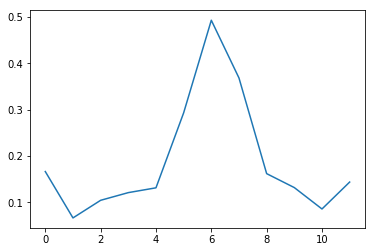

In [5]:
model = ToyMalaria()
prior_traces = model.prior_traces(num_traces=1000)
prior_population = prior_traces.map(lambda trace: trace.named_variables['prevalance'].value)
# prior_prevalence = prior_population.map(get_prevalence)
ground_truth_trace = next(model._trace_generator())
ground_truth_prevalence = ground_truth_trace.named_variables['prevalance'].value
print(ground_truth_prevalence)
plt.plot(ground_truth_prevalence.numpy())

In [ ]:
is_posterior_traces = model.posterior_traces(observe={'prevalance': ground_truth_prevalence}, num_traces=1000, inference_engine=pyprob.InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS)

is_posterior_sinf = is_posterior_traces.map(lambda trace: trace.named_variables['S_inf'].value)
is_posterior_Ecrit = is_posterior_traces.map(lambda trace: trace.named_variables['E_crit'].value)
is_posterior_simm = is_posterior_traces.map(lambda trace: trace.named_variables['S_imm'].value)
is_posterior_X_p_crit = is_posterior_traces.map(lambda trace: trace.named_variables['Xpcrit'].value)
is_posterior_gamma_p = is_posterior_traces.map(lambda trace: trace.named_variables['gamma_p'].value)
plt.plot(ground_truth_prevalence.numpy(),'r-')

print('S_inf = {}'.format(is_posterior_sinf.mean.numpy()))
print('E_crit = {}'.format(is_posterior_Ecrit.mean.numpy()))
print('S_imm = {}'.format(is_posterior_simm.mean.numpy()))
print('X_p_crit = {}'.format(is_posterior_X_p_crit.mean.numpy()))
print('gamma_p = {}'.format(is_posterior_gamma_p.mean.numpy()))


Time spent  | Time remain.| Progress             | Trace     | Accepted|Smp reuse| Traces/sec


In [ ]:
x = model.forward(_eval={"S_inf":is_posterior_sinf.mean,
                         "E_crit":is_posterior_Ecrit.mean,
                         "S_imm":is_posterior_simm.mean,
                         "X_p_crit":is_posterior_X_p_crit.mean,
                         "gamma_p":is_posterior_gamma_p.mean})
plt.plot(x.numpy(),'b')

In [ ]:
plt.plot(ground_truth_prevalence.numpy()+0.001,'r-')
plt.plot(x.numpy(),'b')

In [ ]:
import pyprob.diagnostics

diagnostics.gr